# *DSC Recruitment Task*

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [2]:
data=pd.read_excel(r"C:\Users\priya\OneDrive\Desktop\Training Data.xlsx",nrows=10000)  # inputting the data file
data = data.reindex(np.random.permutation(data.index))     # shuffle the data set

In [3]:
training_data=data.sample(frac=0.80)
test_data=data.drop(training_data.index)
##creating training and test data from the original data frame with a ratio of 80:20
training_data.corr()

##trying to find relations between features and target variable risk_flag.

,Id,income,age,experience,current_job_years,current_house_years,risk_flag
Id,1.000000,-0.003889,-0.009843,-0.006409,-0.011190,-0.010928,-0.054972
income,-0.003889,1.000000,-0.009102,0.007608,0.009788,-0.011321,-0.001195
age,-0.009843,-0.009102,1.000000,-0.010909,-0.014829,-0.029871,-0.010264
experience,-0.006409,0.007608,-0.010909,1.000000,0.642051,0.022246,-0.014410
current_job_years,-0.011190,0.009788,-0.014829,0.642051,1.000000,0.008985,0.013292
current_house_years,-0.010928,-0.011321,-0.029871,0.022246,0.008985,1.000000,-0.003068
risk_flag,-0.054972,-0.001195,-0.010264,-0.014410,0.013292,-0.003068,1.000000


In [4]:

train_df_mean = training_data.loc[:,training_data.columns!="risk_flag"].mean()
train_df_std = training_data.loc[:,training_data.columns!="risk_flag"].std()
train_df_mean["risk_flag"]=0
train_df_std["risk_flag"]=1
train_df_norm = (training_data - train_df_mean)/train_df_std
##scaling all the features to similar values
test_df_mean = test_data.loc[:,test_data.columns!="risk_flag"].mean()
test_df_std  = test_data.loc[:,test_data.columns!="risk_flag"].std()
test_df_mean["risk_flag"]=0
test_df_std["risk_flag"]=1
test_df_norm = (test_data - test_df_mean)/test_df_std
##Scaling test data too
feature_columns=[]
##A empty list to contain all feature columns

In [5]:
del train_df_norm["car_ownership"]
del train_df_norm["city"]
del train_df_norm["house_ownership"]
del train_df_norm["married"]
del train_df_norm["profession"]
del train_df_norm["state"]

del test_df_norm["car_ownership"]
del test_df_norm["city"]
del test_df_norm["house_ownership"]
del test_df_norm["married"]
del test_df_norm["profession"]
del test_df_norm["state"]

##deleting unnecessary features

In [6]:
train_df_norm.head()

,Id,age,current_house_years,current_job_years,experience,income,risk_flag
456,-1.576452,-0.888100,-0.002514,-0.373224,1.311998,1.240050,0.0
920,-1.415761,1.634994,-0.002514,-0.099022,0.644336,-0.997847,1.0
1267,-1.295590,1.693671,-1.439179,-0.373224,1.311998,1.192376,0.0
6459,0.502480,0.285432,-1.439179,-0.921630,1.478914,0.776199,0.0
7021,0.697109,1.224258,-1.439179,-0.647427,0.644336,-0.330215,0.0


In [7]:
test_df_norm.head()

,Id,age,current_house_years,current_job_years,experience,income,risk_flag
9673,1.631935,0.524360,-0.663697,-0.348132,-0.826505,0.211965,0.0
9586,1.601777,0.936084,0.045381,-1.701153,-1.649964,0.616538,0.0
1431,-1.225128,0.171454,0.045381,-0.348132,-0.826505,-1.119756,0.0
4044,-0.319340,1.406625,-0.663697,-0.348132,-0.826505,0.840230,1.0
2442,-0.874668,1.347808,0.045381,-0.889340,0.491028,-1.594957,0.0


In [8]:
age = tf.feature_column.numeric_column("age")
feature_columns.append(age)
exp = tf.feature_column.numeric_column("experience")
feature_columns.append(exp)
feature_layer = layers.DenseFeatures(feature_columns)
feature_layer(dict(train_df_norm))
##adding required features to the feature columns 

<tf.Tensor: shape=(8000, 2), dtype=float32, numpy=
array([[-0.8880996 ,  1.3119982 ],
       [ 1.634994  ,  0.6443359 ],
       [ 1.6936706 ,  1.3119982 ],
       ...,
       [ 1.5763174 , -1.02482   ],
       [-0.53604007, -0.02332645],
       [-0.9467762 , -0.6909888 ]], dtype=float32)>

## *Defining functions for the classification model*

In [9]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  model = tf.keras.models.Sequential()

  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)
   
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model 

In [10]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  return epochs, hist  

In [11]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

In [12]:
train_df_norm.describe()

,Id,age,current_house_years,current_job_years,experience,income,risk_flag
count,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8000.000000
mean,-1.252332e-16,-2.486900e-17,-5.373479e-16,-9.370282e-17,1.167955e-16,-1.065814e-17,0.149750
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.356849
min,-1.734372e+00,-1.709572e+00,-1.439179e+00,-1.744239e+00,-1.692482e+00,-1.746293e+00,0.000000
25%,-8.679769e-01,-8.880996e-01,-7.208464e-01,-6.474274e-01,-8.579044e-01,-8.622822e-01,0.000000
50%,4.305134e-03,-7.950679e-03,-2.514163e-03,-9.902154e-02,-2.332645e-02,9.619795e-03,0.000000
75%,8.675830e-01,8.721983e-01,7.158181e-01,7.235873e-01,8.112515e-01,8.608387e-01,0.000000
max,1.727744e+00,1.693671e+00,1.434150e+00,2.094602e+00,1.645829e+00,1.735447e+00,1.000000


Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
80/80 [==============================] - 0s 652us/step - loss: 0.8099 - accuracy: 0.4389
Epoch 2/100
80/80 [==============================] - 0s 675us/step - loss: 0.7662 - accuracy: 0.4511
Epoch 3/100
80/80 [==============================] - 0s 701us/step - loss: 0.7248 - accuracy: 0.4590
Epoch 4/100
80/80 [==============================] - 0s 598us/step - loss: 0.6860 - accuracy: 0.4750
Epoch 5/100
80/80 [==============================] - 0s 910us/step - loss: 0.6501 - accuracy: 0.4869
Epoch 6/100
80/80 [==============================] - 0s 717us/step - loss: 0.6171 - accuracy: 0.5136
Epoch 7/100
80/80 [==============================] - 0s 675us/step - loss: 0.5874 - accuracy: 0.5391
Epoch 8/100
80/80 [==============================] - 0s 719us/step - loss: 0.5602 - accuracy: 0.5785
Epoch 9/100
80/80 [==============================] - 0s 664us/step - loss: 0.5362 

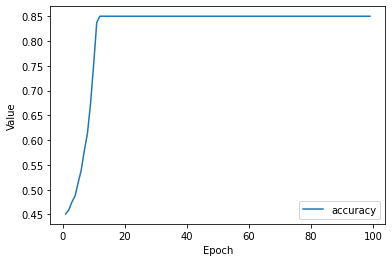

In [13]:
learning_rate = 0.001
epochs = 100
batch_size = 100
label_name = "risk_flag"
classification_threshold = 0.4

METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

my_model = create_model(learning_rate, feature_layer, METRICS)

epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [14]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
20/20 [==============================] - 0s 630us/step - loss: 0.4540 - accuracy: 0.8315


[0.45402950048446655, 0.8314999938011169]

# *Result Accuracy on the test data : 83%*